In [2]:
# import display libs
from IPython.display import Image
%matplotlib inline
from IPython.display import Latex

In [17]:
# import libs
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


# setup figure params
figureparams = {'axes.labelsize': 24,
           'axes.titlesize': 20,
           'axes.linewidth': 1.3,
           'font.size': 20,
           'legend.fontsize': 18,
           'figure.figsize': (10,7),
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 18,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.3,
           'ytick.labelsize': 18,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.3,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(figureparams)
matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['text.latex.unicode']=True
matplotlib.get_configdir()

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


'C:\\Users\\EdwardJansenADC\\.matplotlib'

# R2
### Contents
    1. $R^2$, coefficient of determination
    2. Confidence

## 1. $R^2$, coefficient of determination

In [195]:
# generate binary data
N = 100
S = np.round(np.random.rand(N), 1)
Y_hat = np.round(S)

rand_idx = np.round( np.random.rand(np.int(N/5))*N).astype(int)
Y = Y_hat.copy()
for i in rand_idx:
    if Y[i] == 1.:
        Y[i] = 0.
    else:
        Y[i] = 1.

In [199]:
# generate continuous data
x = np.linspace(0,N-1, N)
y = x + np.random.randn(N)*10
y_hat = x.copy()

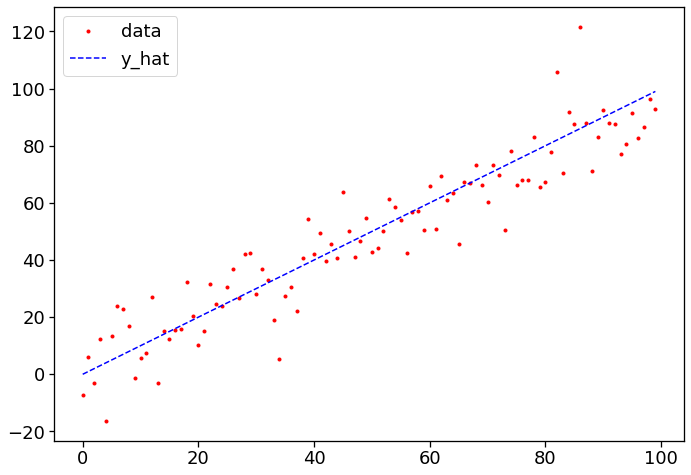

In [200]:
# visualize everything
plt.plot(x, y, 'r.', label='data')
plt.plot(x, y_hat, 'b--', label='y_hat')
plt.legend()
plt.show()

In [203]:
# Compute simple R2
res = y - y_hat
y_norm = y - np.mean(y)
R2 = 1 - np.sum(res**2) / np.sum( y_norm**2 )


# adjusted R2
N = 100 # number obs
p = 1 # number of expl. vars

corr_factor = (N-1) / (N - p - 1)
R2_adj = 1 - corr_factor*(1-R2)

# print results
print("R2: "+str(R2))
print("adjusted R2: " + str(R2_adj))

R2: 0.8718575398995342
adjusted R2: 0.8705499637760601


## 2. Confidence
#### 2a. Analytical confidence interval

In [206]:
# significance
# assumptions:
#       linearity
#       normal distr of target var and res
#       independence of target var and res
#       res are independent of expl vars

#       H0: res and data have same variance (i.e. model does not fit data)

#   the quantity below follows a Fisher distribution
test_statistic = ( (np.sum(y_norm**2) - np.sum(res**2)) / p )  /   ( np.sum(res**2) / N-p-1)

from scipy.stats import f

# compute critical value
alpha = 0.05
cv = f.ppf(1.0 - alpha, p, N-p-1)

# therefore, H0 is rejected when the test_statistic is greater than F( 1- alpha, p, N-p-1), with alpha the significance level
test_statistic >= cv # ?
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html


# confidence interval
# https://stats.stackexchange.com/questions/175026/formula-for-95-confidence-interval-for-r2

# based on SE_R2, see second answer in stackexchange
# only valid for large sample sizes (N-k-1) > 60 and for normal distributions

SE_R2 = np.sqrt( (4*R2*(1-R2)**2*(N-p-1)**2) / ((N**2-1)*(N+3))  )

CI_low = R2 - 2*SE_R2
CI_up = R2 + 2*SE_R2
print("SE; real R2 lies within: (" + str(CI_low) + ", " + str(CI_up) + ")")
print("Observed R2: " + str(R2))



SE; real R2 lies within: (0.8256401950764236, 0.9180748847226448)
Observed R2: 0.8718575398995342


#### 2b. Bootstrapped confidence interval

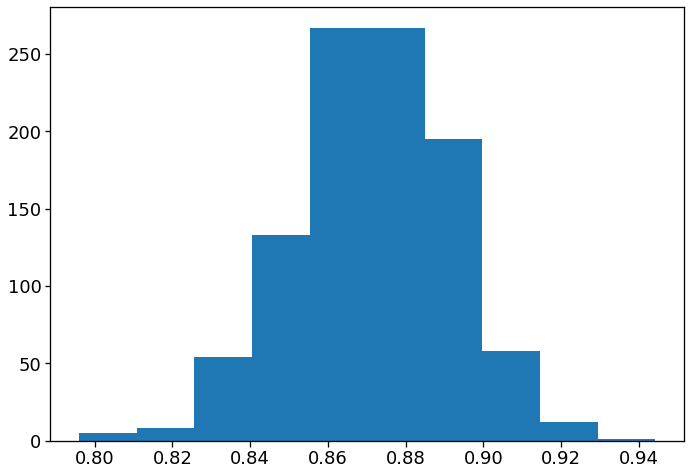

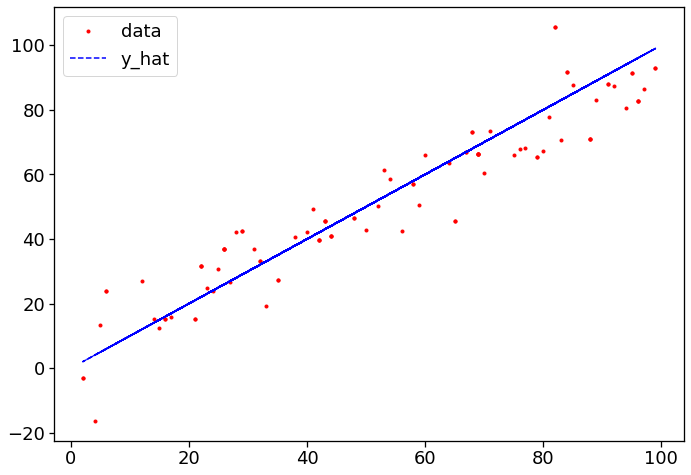

Bootstrap; real R2 lies within: (0.831, 0.91)
SE; real R2 lies within: (0.826, 0.918)
Observed R2: 0.872


In [207]:
# bootstrap 
# we bootstrap through resampling the data and then computing the prediction y_hat 
# bit weird in this case, because we construct the data instead of actually fitting a model.
# but we can do it nonetheless
# https://www.textbook.ds100.org/ch/18/hyp_regression.html

# consider (x[i], y[i]) to be a pair and then resample those
n_iter = 1000
R2_boots = []
for i in range(n_iter):
    idx = (np.random.rand(N)*N).astype(int)
    # bootstrap pairs
    x = np.linspace(0,N-1, N)
    x_boot = x[idx]
    y_boot = y[idx]
    # compute model y_hat
    y_hat = x_boot.copy()            # here normally goes how y_hat is computed from y
    # compute res
    res = y_boot - y_hat
    y_norm = y_boot - np.mean(y)
    R2_tmp = 1 - np.sum(res**2) / np.sum( y_norm**2 )
    R2_boots.append(R2_tmp)

# check distr bootstrapped R2
plt.hist(R2_boots)
plt.show()

# check
plt.plot(x_boot, y_boot, 'r.', label='data')
plt.plot(x_boot, y_hat, 'b--', label='y_hat')
plt.legend()
plt.show()


def confidence_interval(sim, alpha):
    """
    Return 2-sided symmetric confidence interval specified
    by p.
    """
    n = len(sim)
    u_pval = 1 - alpha/2
    l_pval = alpha / 2
    l_idx = int(np.floor(n*l_pval))
    u_idx = int(np.floor(n*u_pval))
    return(sim[l_idx], sim[u_idx])

bounds = confidence_interval(np.sort(R2_boots), 0.05)
print("Bootstrap; real R2 lies within: (" + str(np.round(bounds[0],3)) + ", " + str(np.round(bounds[1],3)) + ")")
print("SE; real R2 lies within: (" + str(np.round(CI_low, 3)) + ", " + str(np.round(CI_up, 3)) + ")")
print("Observed R2: " + str(np.round(R2, 3)))
